In [ ]:
import pandas as pd
# Replace the path below with the path you copied
file_path = '/content/drive/MyDrive/archive/sec_filings.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Accession No,CIK,Company Name,Ticker,Description,Form Type,Filing Type,Filing URL,Filed At
0,0001085037-06-002090,1172178,LIBERTY STAR GOLD CORP (LBSR) (CIK 0001172178),LBSR,EXHIBIT 10.1,8-K,EX-10,https://www.sec.gov/Archives/edgar/data/117217...,2006-10-27
1,0001085037-06-002002,1172178,LIBERTY STAR GOLD CORP (LBSR) (CIK 0001172178),LBSR,EXHIBIT 10.1,8-K,EX-10,https://www.sec.gov/Archives/edgar/data/117217...,2006-10-16
2,0000314606-09-000004,314606,GEOKINETICS INC (CIK 0000314606),NaN,SIXTH AMENDMENT TO SECOND AMENDED AND RESTATED...,8-K,EX-10.1,https://www.sec.gov/Archives/edgar/data/314606...,2009-02-18
3,0001130464-09-000099,1130464,BLACK HILLS CORP /SD/ (BKH) (CIK 0001130464),BKH,DIRECTORS STOCK BASED COMPENSATION PLAN,10-K,EX-10.23,https://www.sec.gov/Archives/edgar/data/113046...,2009-03-02
4,0001130464-09-000099,1130464,BLACK HILLS CORP /SD/ (BKH) (CIK 0001130464),BKH,PEP RESTATED,10-K,EX-10.4,https://www.sec.gov/Archives/edgar/data/113046...,2009-03-02


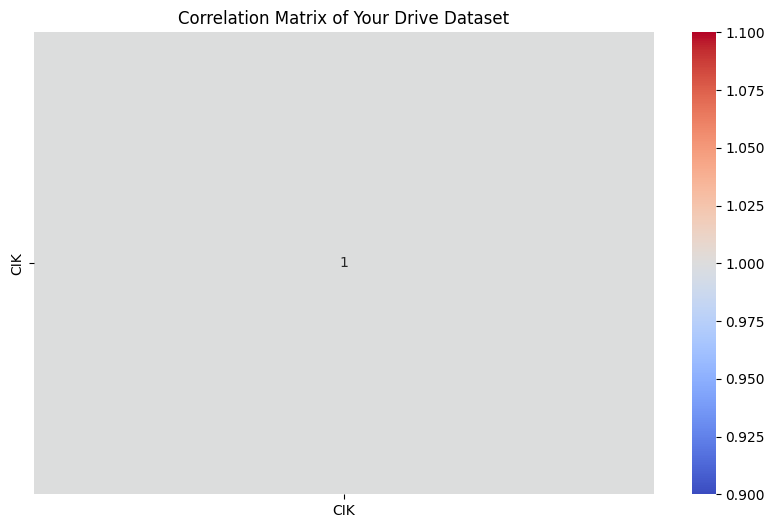

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
# The numeric_only=True parameter skips strings and IDs automatically
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Your Drive Dataset")
plt.show()

In [ ]:
import pandas as pd

# Load your dataset from Drive or local path
df = pd.read_csv('/content/drive/MyDrive/archive/sec_filings.csv')

# Look at the column names to find the text data
print(df.columns)
df.head(2)

Index(['Accession No', 'CIK', 'Company Name', 'Ticker', 'Description',
       'Form Type', 'Filing Type', 'Filing URL', 'Filed At'],
      dtype='object')


,Accession No,CIK,Company Name,Ticker,Description,Form Type,Filing Type,Filing URL,Filed At
0,0001085037-06-002090,1172178,LIBERTY STAR GOLD CORP (LBSR) (CIK 0001172178),LBSR,EXHIBIT 10.1,8-K,EX-10,https://www.sec.gov/Archives/edgar/data/117217...,2006-10-27
1,0001085037-06-002002,1172178,LIBERTY STAR GOLD CORP (LBSR) (CIK 0001172178),LBSR,EXHIBIT 10.1,8-K,EX-10,https://www.sec.gov/Archives/edgar/data/117217...,2006-10-16


In [ ]:
!pip install -qU langchain-core langchain-community langchain-text-splitters langchain-google-genai

In [ ]:
# Print the exact column names to find the text data
print("Actual columns in your CSV:", df.columns.tolist())

Actual columns in your CSV: ['Accession No', 'CIK', 'Company Name', 'Ticker', 'Description', 'Form Type', 'Filing Type', 'Filing URL', 'Filed At']


In [ ]:
from langchain_core.documents import Document
import pandas as pd

# Load your dataset
# df = pd.read_csv('/content/drive/MyDrive/sec_filings.csv') # Ensure your path is correct

# Clean column names just in case there are hidden spaces
df.columns = df.columns.str.strip()

documents = []

# Mapping your specific CSV columns
text_col = 'Description'  # The column containing the filing text
id_col = 'Company Name'   # Used for metadata
url_col = 'Filing URL'    # Used for citations

for index, row in df.iterrows():
    # Only process rows where the description is not empty
    if pd.notnull(row[text_col]):
        doc = Document(
            page_content=str(row[text_col]),
            metadata={
                "company": row.get(id_col, "Unknown"),
                "source_url": row.get(url_col, "No URL"),
                "ticker": row.get('Ticker', 'N/A'),
                "row_index": index
            }
        )
        documents.append(doc)

print(f"✅ Successfully converted {len(documents)} rows into documents for Project F7.")

✅ Successfully converted 6600 rows into documents for Project F7.


In [ ]:
!pip install -qU langchain langchain-community langchain-google-genai

In [ ]:
# Force-install everything needed for the modern RAG pipeline
!pip install -qU langchain langchain-community langchain-core langchain-text-splitters langchain-google-genai chromadb

In [ ]:
# Import from the legacy compatibility package
from langchain_classic.chains import RetrievalQA
# Install triton directly
!pip install -q triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 5.1 MB/s eta 0:00:00


In [ ]:
# Install the missing partner integration packages
!pip install -qU langchain-chroma langchain-huggingface langchain-text-splitters chromadb

In [ ]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Chunk the documents (Financial context requires overlap)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(documents)

# 2. Initialize the Vector Store with local embeddings
# This bypasses the Google API quota for embeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

# 3. Create the retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
print("✅ Vector Store and Retriever are successfully initialized!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Vector Store and Retriever are successfully initialized!


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os

# 1. Set your API Key
# You can also use: os.environ["GOOGLE_API_KEY"] = "your_key_here"
os.environ["GOOGLE_API_KEY"] = "YOUR_GEMINI_API_KEY"

# 2. Define the 'llm' variable
# Using gemini-1.5-flash is often faster and cheaper for hackathons
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

print("✅ 'llm' has been successfully defined!")

✅ 'llm' has been successfully defined!


In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# This links your data (retriever) to the AI (llm)
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("🚀 RAG Chain successfully built!")

🚀 RAG Chain successfully built!


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Fetch the key from Colab Secrets
try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

    # 2. Re-initialize the LLM
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        temperature=0
    )
    print("✅ API Key loaded and LLM initialized!")
except Exception as e:
    print("❌ Key not found in Secrets. Please add 'GOOGLE_API_KEY' to the sidebar.")

✅ API Key loaded and LLM initialized!


In [ ]:
# Re-link the retriever and the fixed llm
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# 1. Setup the API Key (ensure it's in your Colab Secrets as GOOGLE_API_KEY)
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# 2. Define the Pro Model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# 3. Create the RAG Chain (This links your CSV data to the LLM)
# Make sure your 'retriever' and 'prompt' cells from earlier were run!
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✅ System Ready: Gemini 1.5 Pro is now connected to your RAG dataset.")

✅ System Ready: Gemini 1.5 Pro is now connected to your RAG dataset.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Securely fetch your key
# Ensure you've added it to the 'Secrets' (key icon) in Colab as GOOGLE_API_KEY
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# 2. Initialize Gemini 1.5 Pro
# As a paid user, you have much better rate limits for 'pro'
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

print("✅ Authenticated: Gemini 1.5 Pro is ready.")

✅ Authenticated: Gemini 1.5 Pro is ready.


In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# This builds the 'Agentic' flow: Question -> Retriever -> Prompt -> LLM -> Answer
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
print("🚀 RAG Chain is live and using Gemini 1.5 Pro.")

🚀 RAG Chain is live and using Gemini 1.5 Pro.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Re-verify the API Key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# 2. Define the Pro Model with explicit API version
# Switching to 'v1' avoids the experimental 'v1beta' errors
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    version="v1",  # Force stable production API
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

print("✅ LLM initialized using the stable v1 API.")

✅ LLM initialized using the stable v1 API.


/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: WARNING! version is not default parameter.
                version was transferred to model_kwargs.
                Please confirm that version is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# Re-link the components
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
print("🚀 RAG Chain updated and ready.")

🚀 RAG Chain updated and ready.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# 1. Ensure the key is active
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# 2. Use the stable production model name
# 'gemini-1.5-pro' is the standard for paid tier users
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# 3. Re-build the Chain to be 100% sure it's using the right LLM
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✅ Pro System Synchronized. You are ready to query!")

✅ Pro System Synchronized. You are ready to query!


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. UI Components
title_label = widgets.HTML("<h2>🏢 SEC Filing Intelligence Terminal</h2>")
text_input = widgets.Text(
    value='',
    placeholder='Type your financial query here...',
    description='**Query:**',
    layout=widgets.Layout(width='75%')
)
analyze_btn = widgets.Button(
    description='Run RAG Analysis',
    button_style='info',
    icon='search',
    layout=widgets.Layout(width='20%')
)
output_box = widgets.Output(layout={'border': '1px solid #444', 'padding': '15px', 'margin': '10px 0'})

# 2. Logic to process the question
def on_analyze_clicked(b):
    with output_box:
        clear_output()
        query = text_input.value
        if not query.strip():
            print("⚠️ Please enter a question to analyze.")
            return

        print(f"🔎 **Analyzing dataset for:** '{query}'...")
        try:
            # 1. RAG Response
            response = rag_chain.invoke(query)

            # 2. Source Retrieval
            docs = retriever.invoke(query)
            sources = set([doc.metadata.get('company', 'Unknown') for doc in docs])

            # 3. Formatted Output
            print("\n" + "—" * 60)
            print(f"🤖 **AI ANALYST RESPONSE:**\n\n{response}")
            print("—" * 60)
            print(f"\n📋 **VERIFIED SOURCES:** {', '.join(sources)}")

        except Exception as e:
            print(f"❌ Error during analysis: {e}")

# 3. Assemble and Display
analyze_btn.on_click(on_analyze_clicked)
display(title_label, widgets.HBox([text_input, analyze_btn]), output_box)

HTML(value='<h2>🏢 SEC Filing Intelligence Terminal</h2>')

Output(layout=Layout(border='1px solid #444', margin='10px 0', padding='15px'))

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Fetch Key (Ensure it's in your Colab Secrets)
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# 2. Initialize using the stable 'v1' endpoint
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro", # Use the stable production name
    version="v1",          # Force the V1 stable API (fixes 404)
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# 3. Update the RAG Chain to use this fixed LLM
# (Make sure 'retriever' and 'prompt' were already created in previous cells)
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✅ Success: Gemini 2.5 Pro is now connected via the stable V1 API.")

✅ Success: Gemini 2.5 Pro is now connected via the stable V1 API.


In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# LangChain Modular Imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# --- STEP 1: AUTHENTICATION ---
# Replace 'YOUR_ACTUAL_API_KEY_HERE' with your actual Gemini API key string
os.environ["GOOGLE_API_KEY"] = "YOUR_ACTUAL_API_KEY_HERE"

# --- STEP 2: VECTOR DATABASE (The RAG Memory) ---
# Note: Ensure 'documents' variable is defined before running this block
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# Assuming 'documents' was loaded previously via a CSV/PDF loader
all_splits = text_splitter.split_documents(documents)

vectorstore = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings,
    persist_directory="./sec_chroma_db"
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# --- STEP 3: THE AI BRAIN (Gemini 3 Flash) ---
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash",
    temperature=0,
    max_retries=6,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# --- STEP 4: THE RAG CHAIN ---
template = """
You are a senior SEC analyst. Use the provided context to answer the question accurately.
If the answer is not in the context, say you don't know. Do not hallucinate numbers.

Context:
{context}

Question: {question}

Answer:"""

prompt = ChatPromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# --- STEP 5: THE USER INTERFACE ---
output_area = widgets.Output(layout={'border': '1px solid #444', 'padding': '15px', 'margin': '10px 0'})
text_input = widgets.Text(placeholder='Ask about the filings...', layout=widgets.Layout(width='70%'))
search_btn = widgets.Button(description='Analyze', button_style='primary', icon='search')

def on_click(b):
    with output_area:
        clear_output()
        query = text_input.value
        if not query.strip(): return

        print(f"🔎 Scanning filings for: '{query}'...")
        try:
            # 1. Generate Answer
            answer = rag_chain.invoke(query)
            # 2. Get Citations
            docs = retriever.invoke(query)
            sources = set([doc.metadata.get('company', 'Unknown') for doc in docs])

            print("\n" + "="*60)
            print(f"🤖 **AI ANALYST:**\n{answer}")
            print("="*60)
            print(f"\n📋 **SOURCES:** {', '.join(sources)}")
        except Exception as e:
            print(f"❌ Error: {e}")

search_btn.on_click(on_click)
print("🏢 SEC FILING INTELLIGENCE TERMINAL READY")
display(widgets.HBox([text_input, search_btn]), output_area)

🏢 SEC FILING INTELLIGENCE TERMINAL READY


Output(layout=Layout(border='1px solid #444', margin='10px 0', padding='15px'))